**Import Depencencies**

In [30]:
# %pip install pandas as pd
# %pip install numpy as np
# %pip install scikit-learn
# %pip install matplotlib.pyplot as plt
# %pip install seaborn

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns


**Create DataFrame**

Import CSVs

In [32]:
# SHIPPING DASHBOARD CSV
shipments_df = pd.read_csv("./shipments_2023.csv")

# GAS PRICE AVERAGES CSV
monthly_gas_averages = pd.read_csv("./gas_averages - U.S._All_Grades_All_Formulations_Retail_Gasoline_Prices (2) (1).csv")

# CONVERT DATE COLUMN IN SHIPMENTS_DS TO DATETIME
shipments_df['Project Date'] = pd.to_datetime(shipments_df['Project Date'], format='%Y-%m-%d')

# ADJUST PROJECT DATE TO MATCH MONTHLY GAS AVG & MERGE
shipments_df['month_year'] = shipments_df['Project Date'].dt.month.astype(str) + '/' + shipments_df['Project Date'].dt.year.astype(str)
shipments_df = pd.merge(shipments_df, monthly_gas_averages, how='left', left_on='month_year', right_on='Month', suffixes=('_shipments', '_gas_averages'))
shipments_df = shipments_df.rename(columns={'U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon': 'avg_gas_price'})

Create Data Frame - LTL DATA ONLY

In [33]:
# CONVERT DATE COLUMN IN SHIPMENTS_DS TO DATETIME
shipments_df['Project Date'] = pd.to_datetime(shipments_df['Project Date'], format='%Y-%m-%d')

# MERGE NATIONAL GAS PRICE AVERAGES WITH PROJECT DATE
shipments_df['month_year'] = shipments_df['Project Date'].dt.month.astype(str) + '/' + shipments_df['Project Date'].dt.year.astype(str)
shipments_df = pd.merge(shipments_df, monthly_gas_averages, how='left', left_on='month_year', right_on='Month')

# OUTBOUND
outbound_columns = ['Outbound # of Pallets', 'Outbound Total Weight (in lbs)', 'Outbound Type of Truck', 'Price Quoted for Outbound', 'One Way Distance To/From Warehouse', 'U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon']
outbound_df = shipments_df[outbound_columns].copy()
outbound_df = outbound_df[outbound_df['Outbound Type of Truck'] == 'LTL']

# INBOUND
inbound_columns = ['Return # of Pallets', 'Return Total Weight', 'Return Type of Truck', 'Price Quoted for Return', 'One Way Distance To/From Warehouse', 'U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon']
inbound_df = shipments_df[inbound_columns].copy()
inbound_df = inbound_df[inbound_df['Return Type of Truck'] == 'LTL']

#CREATE WORKING DF
df = pd.DataFrame()
df['pallets'] = pd.concat([outbound_df['Outbound # of Pallets'], inbound_df['Return # of Pallets']], ignore_index=True)
df['weight'] = pd.concat([outbound_df['Outbound Total Weight (in lbs)'], inbound_df['Return Total Weight']], ignore_index=True)
df['distance'] = pd.concat([outbound_df['One Way Distance To/From Warehouse'], inbound_df['One Way Distance To/From Warehouse']], ignore_index=True)
df['avg_gas_price'] = pd.concat([outbound_df['U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon'], inbound_df['U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon']], ignore_index=True)
df['quote'] = pd.concat([outbound_df['Price Quoted for Outbound'], inbound_df['Price Quoted for Return']], ignore_index=True)

# CLEAN UP COLUMNS
df['weight'] = df['weight'].str.replace(',', '').str.replace(' lbs', '').astype(int)
df['distance'] = df['distance'].str.replace(',', '').str.replace(' miles', '').astype(float)
df['quote'] = df['quote'].str.replace("$", '').str.replace(',', '').astype(float)
df['pallets'] = df['pallets'].astype(float)
df = df.dropna(axis=0)

# THROW IN OLD CALCULATOR RESULTS
df["Old Calculator"] = ((df["distance"] * .114 + 105) * df["pallets"]) + 150 + 22.5

# SHOW RESULTS
print(df.iloc[:, 0:5])

     pallets  weight  distance  avg_gas_price    quote
0        3.0    4100      89.0          3.445   510.00
1        3.0    4000     936.0          3.445   925.17
2        3.0    4100     747.0          3.445   921.33
3        6.0    8800     799.0          3.445  1656.31
4        4.0    5000     960.0          3.445  1198.72
..       ...     ...       ...            ...      ...
157      3.0    3000     747.0          3.257   941.33
158      2.0    1800     907.0          3.257   653.73
159      2.0    1000    2200.0          3.257   693.87
160      4.0    2800    1832.0          3.257  1299.09
161      3.0    2600     955.0          3.257   984.56

[159 rows x 5 columns]


**Train Model**

In [34]:
# INDEPENDENT VARIABLES
X = df[['pallets', 'weight', 'distance', 'avg_gas_price']]

# DEPENDENT VARIABLE
y = df['quote']

# SPLIT DATASET
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

# TRAINING MODEL
regressor = LinearRegression()
regressor.fit(X_train,y_train)

# VALIDATING MODEL
y_pred = regressor.predict(X_test)


Comparing Actual vs Predicted data points

In [35]:
results = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

print(results.head())

      Actual    Predicted
7    1078.34  1026.947831
40   1224.49  1086.700525
96    541.24   703.009078
45   1800.00  1777.695627
111   653.16   795.712302


**Graph Results**

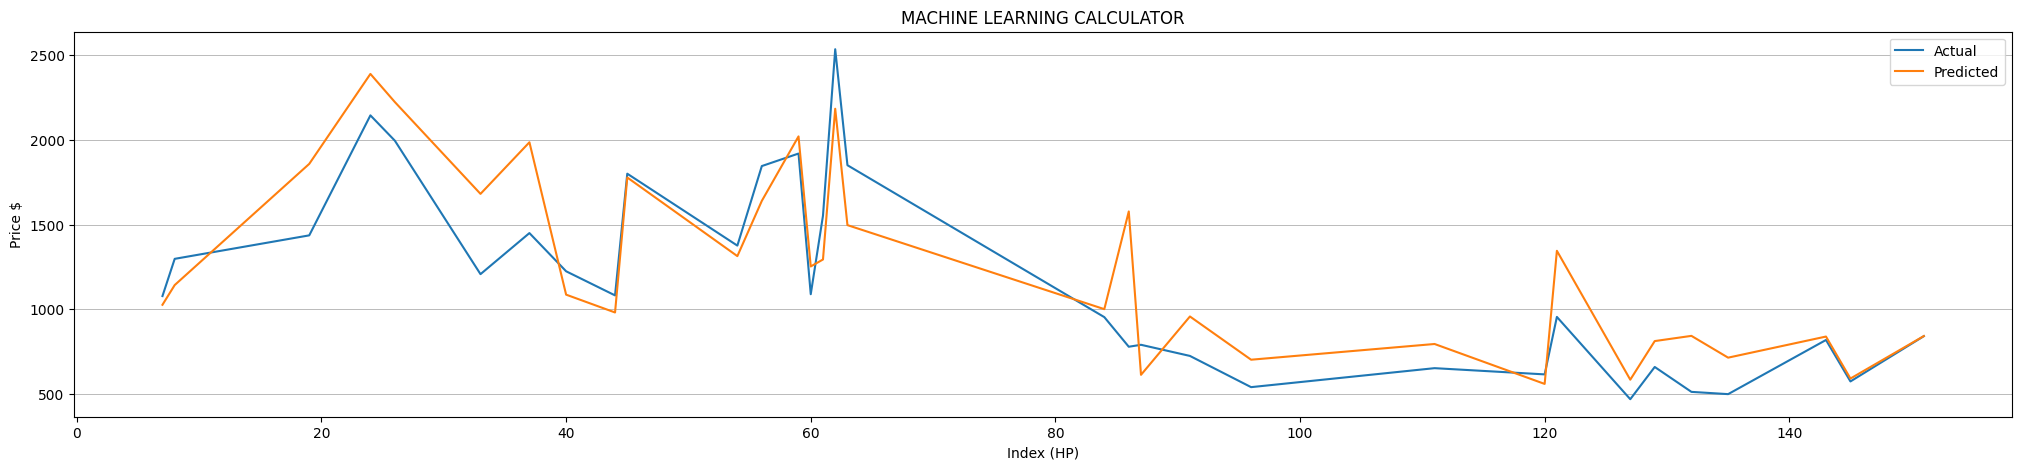

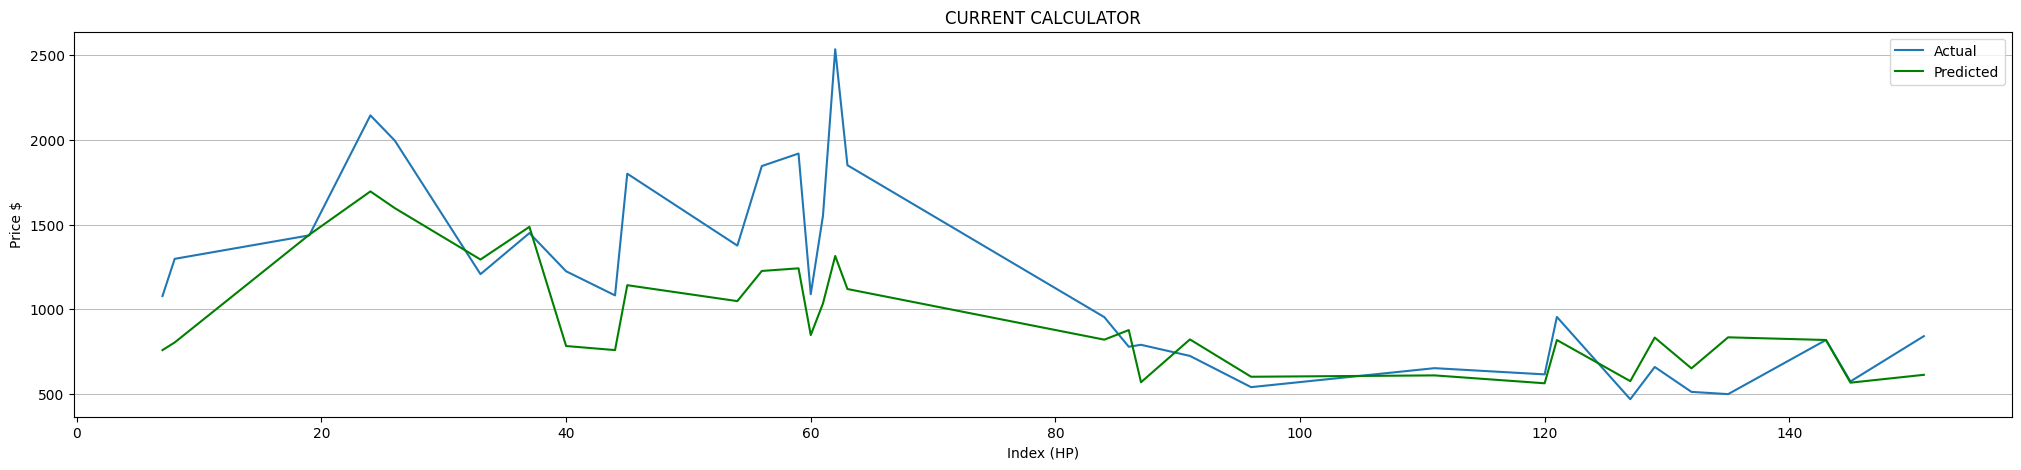

In [36]:
results['Old Calculator'] = df['Old Calculator']

results.sort_index(inplace=True)

# MACHINE LEARNING CALCULATOR
plt.figure(figsize=(25, 5))
plt.plot(results.index, results['Actual'], label='Actual', marker='')
plt.plot(results.index, results['Predicted'], label='Predicted', marker='')

plt.xlabel('Index (HP)')
plt.ylabel('Price $')
plt.title('MACHINE LEARNING CALCULATOR')
plt.legend()
plt.grid(axis='y', linestyle='-', linewidth='0.5', color='gray', alpha=0.75)
plt.show()


# CURRENT CALCULATOR
plt.figure(figsize=(25, 5))
plt.plot(results.index, results['Actual'], label='Actual', marker='')
plt.plot(results.index, results['Old Calculator'], label='Predicted', marker='', color='green')

plt.xlabel('Index (HP)')
plt.ylabel('Price $')
plt.title('CURRENT CALCULATOR')
plt.legend()
plt.grid(axis='y', linestyle='-', linewidth='0.5', color='gray', alpha=0.75)
plt.show()


**Statistics & Coefficients**

In [37]:
ml = '(ML):      '
old = '(CURRENT): '
sep = """
------------------
"""

# MEAN ABSOLUTE ERROR
print("\nMEAN ABSOLUTE ERROR: ")
print(f"{ml} {metrics.mean_absolute_error(results['Actual'], results['Predicted']):.2f}")
print(f"{old} {metrics.mean_absolute_error(df['quote'], df['Old Calculator']):.2f}")
print(sep)

# TOTAL ERROR
total_error_ML = sum(results['Predicted']) - sum(results['Actual'])
total_error_OLD = sum(df['Old Calculator']) - sum(df['quote'])
print("TOTAL ERROR: ")
print(f"{ml} {total_error_ML:.2f}")
print(f"{old} {total_error_OLD:.2f}")
df['Old Calculator - With 15% Cost Cushion'] = df['Old Calculator'] + (df['Old Calculator'] * 0.15)
print("(CURRENT WITH 15% COST CUSHION): ", f"{sum(df['Old Calculator - With 15% Cost Cushion']) - sum(df['quote']):.2f}")
print(sep)

# X INTERCEPT
print("X INTERCEPT: ")
print(f"{ml} {regressor.intercept_:.2f}")
print(old, '150')
print(sep)

# COEFFICIENTS
coefficients = regressor.coef_
variable_names = X.columns
print('COEFFICIENTS:\n')
print(ml)
for variable, coefficient in zip(variable_names, coefficients):
    print(f"{variable}: {coefficient:.2f}")

print('\n')
print(old, '\ndistance: 0.114')


MEAN ABSOLUTE ERROR: 
(ML):       210.01
(CURRENT):  316.06

------------------

TOTAL ERROR: 
(ML):       2860.18
(CURRENT):  -43580.17
(CURRENT WITH 15% COST CUSHION):  -21659.84

------------------

X INTERCEPT: 
(ML):       -127.89
(CURRENT):  150

------------------

COEFFICIENTS:

(ML):      
pallets: 112.76
weight: 0.11
distance: 0.71
avg_gas_price: -58.22


(CURRENT):  
distance: 0.114


Regression / X.Feature

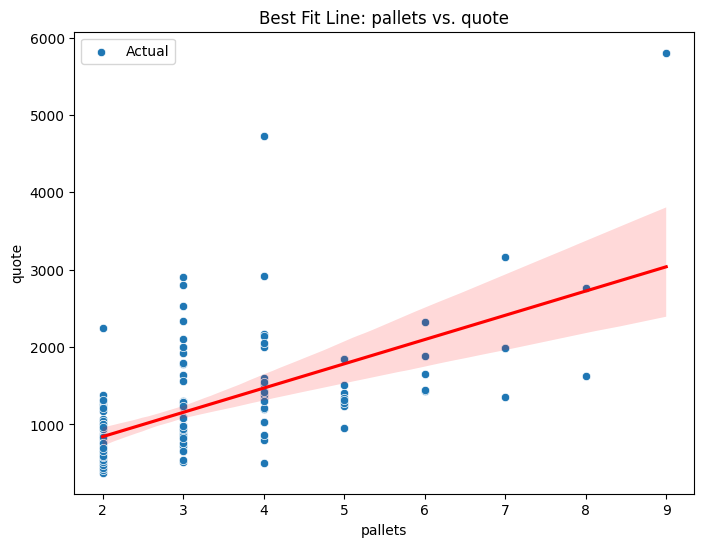

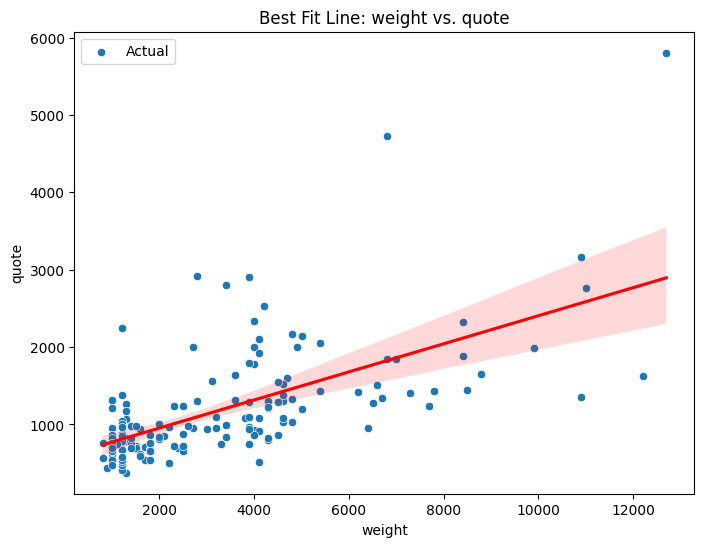

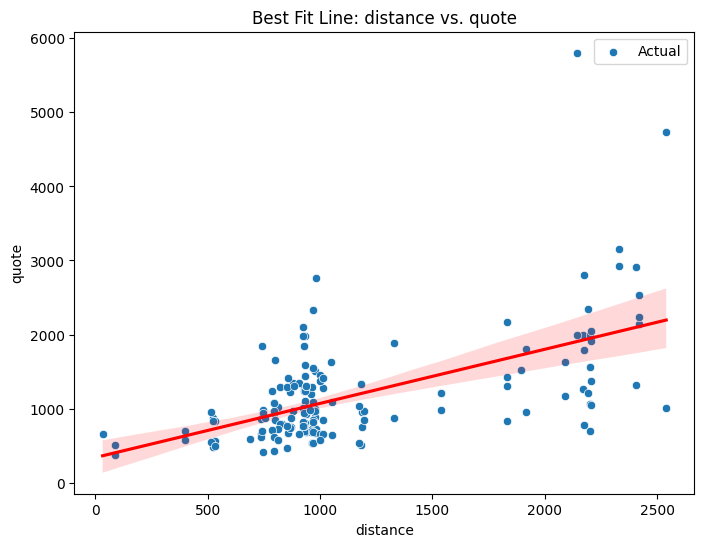

In [38]:
y_pred_graphs = regressor.predict(X)

for feature in X.columns:

    # REMOVE GAS PRICE CHART.. DOESNT MAKE SENSE TO ME
    if feature != 'avg_gas_price':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X[feature], y=y, label="Actual")
        
        # BEST FIT LINE
        sns.regplot(x=X[feature], y=y, line_kws={'color':'red'}, scatter=False)
        plt.title(f"Best Fit Line: {feature} vs. {y.name}")

        # LINEAR REGRESSION
        # sns.lineplot(x=X[feature], y=y_pred_graphs, color='red', label="Linear Regression")
        # plt.title(f"Linear Regression: {feature} vs. {y.name}")

        plt.xlabel(feature)
        plt.ylabel(y.name)
        plt.legend()
        plt.show()